Dices detection
=========================================
***Komunikacja człowiek-komputer 2021***   

**Authors**: Katarzyna Badio, Julia Chabora  

### Importing libraries

In [136]:

import numpy as np
import os
import cv2
from matplotlib import pylab as plt 
from ipywidgets import interact
import pandas as pd
import csv

### Preprocessing images

In [137]:
#directory = r'./images'
#directory = r'./dices/selected-dataset-images'
#directory = r'./dices/board-game-dices'
#directory = r'./dices/selected-board-game-dices'
directory = r'./dices/100_dices'
#directory = r'./dices/Test_folder'

dices = []
dices_paths = []
original_dices = []
i = 0
for dice_image in os.scandir(directory):
    dices.append(dice_image.path)
    dices_paths.append(dice_image.path)
    # plt.figure(figsize=(30, 30))

    img = cv2.imread(dices[i])
    original_dices.append(img)
    
    # 0. Change colorscale to gray
    imggrayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. Blurring dices to remove sharp edges
    blur = cv2.blur(imggrayscale, (3, 3), 0)
    
    # 2. Threshold
    _, thresholded = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)
    
    # 3. Erosion
    kernel = np.ones((1,1),np.uint8)
    erosion = cv2.erode(thresholded,kernel,iterations = 2)
    
    # 4. Dilation
    kernel1 = np.ones((3,3),np.uint8)
    dices[i] = cv2.dilate(erosion,kernel1,iterations = 1)
    
    
    # ax = plt.subplot(40, 3, i+1)
    # ax.imshow(dices[i], cmap='gray')
    # ax.set_xticks([]), ax.set_yticks([])
    # ax.axis([0, img.shape[1], img.shape[0], 0])
    
    i += 1 


## Results

/tmp/ipykernel_2583/3176129528.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(30, 30))


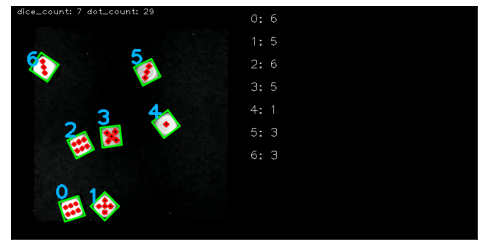

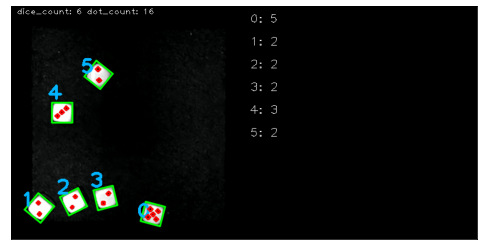

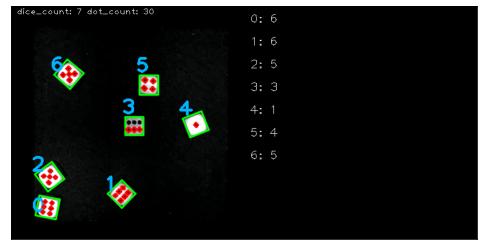

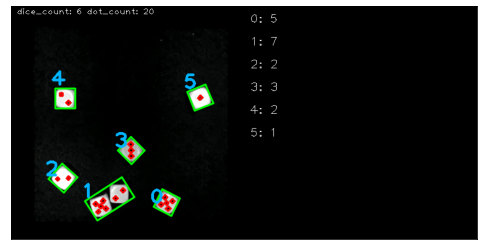

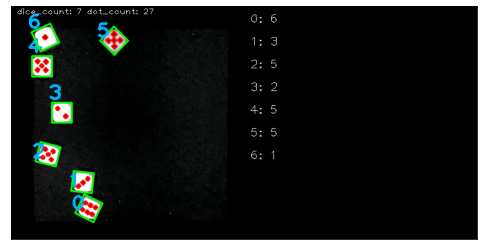

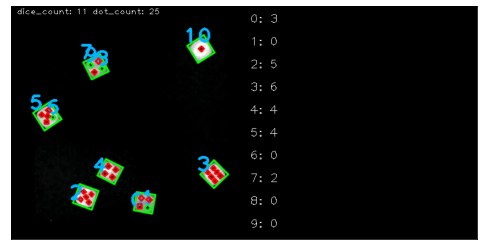

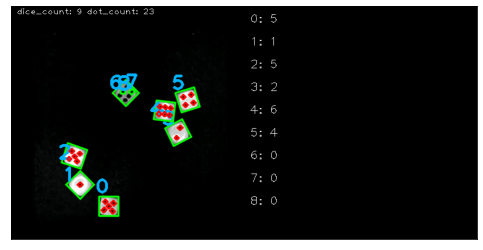

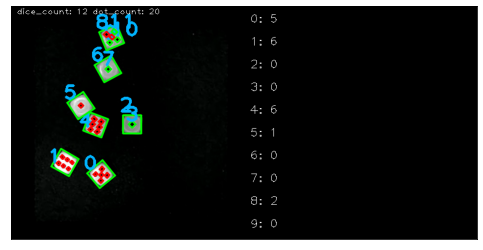

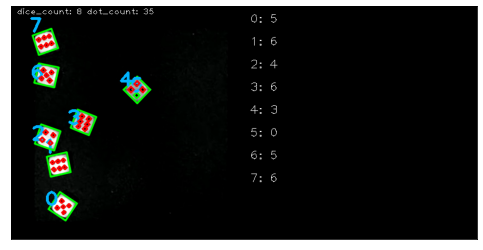

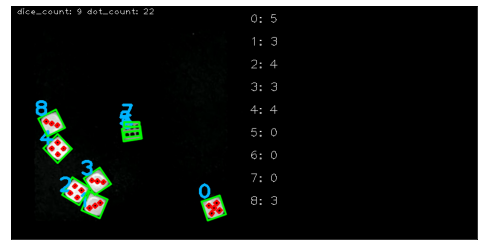

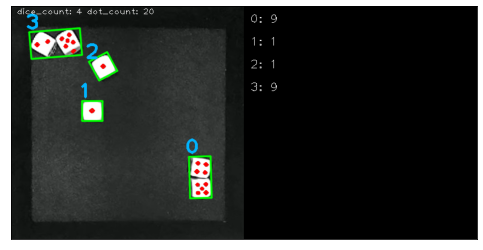

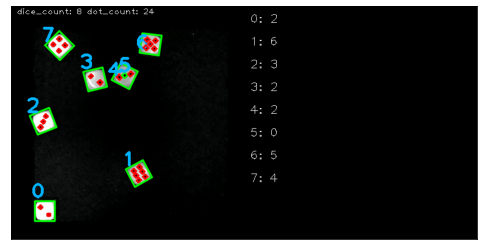

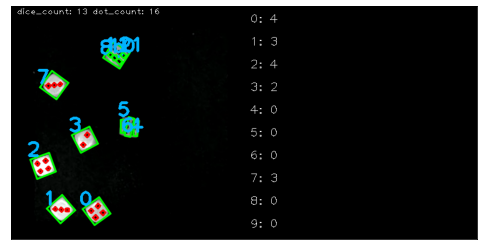

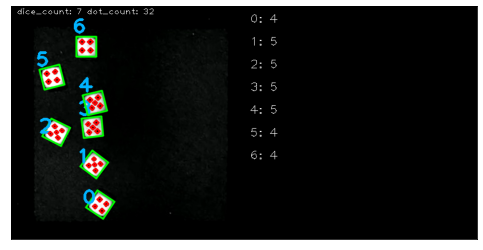

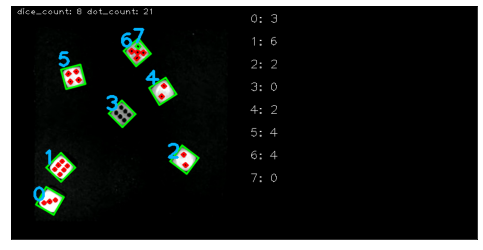

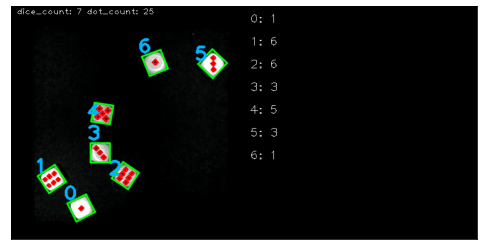

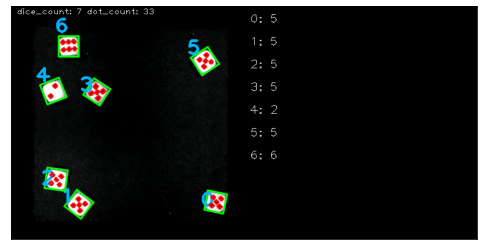

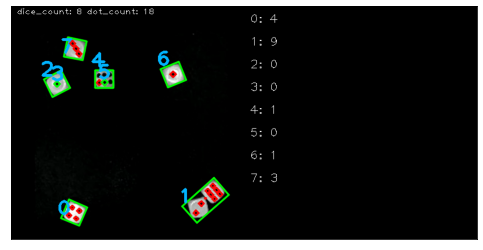

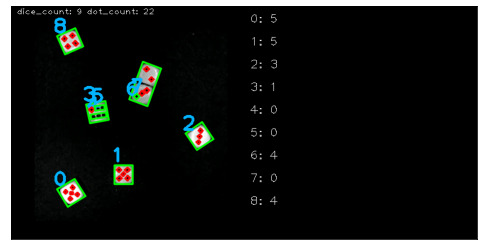

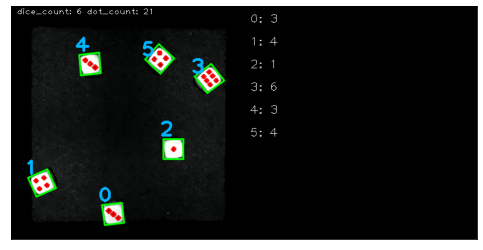

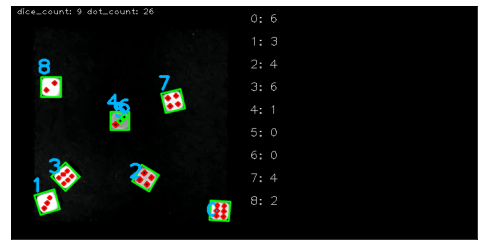

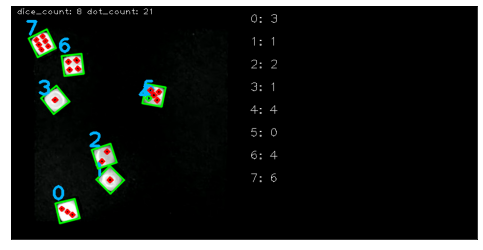

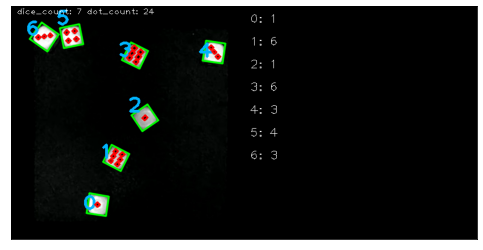

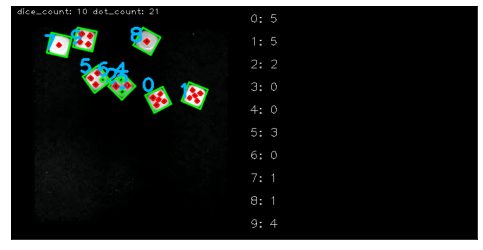

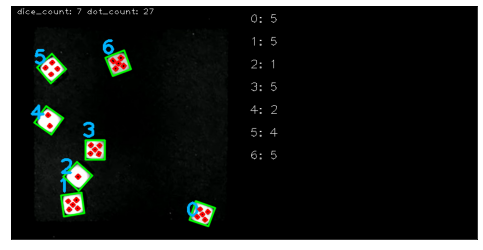

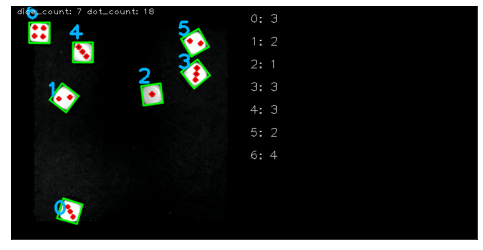

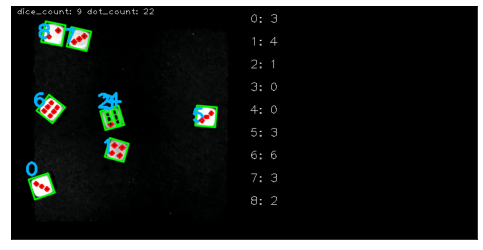

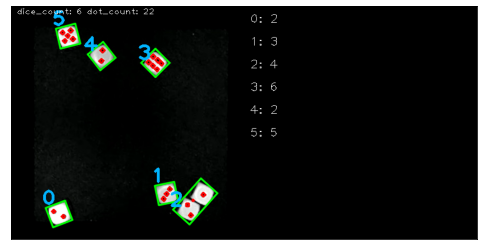

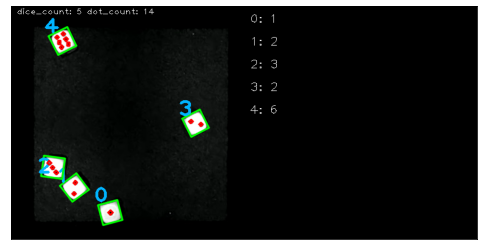

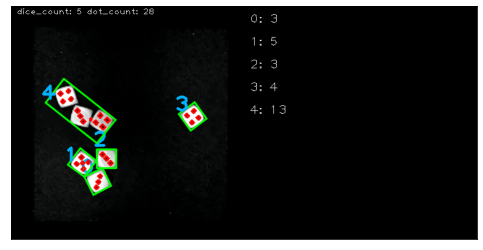

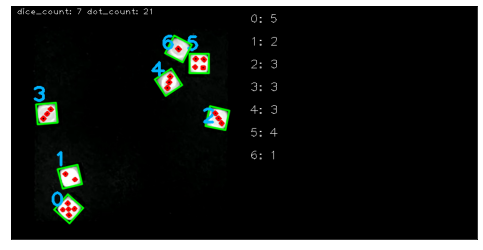

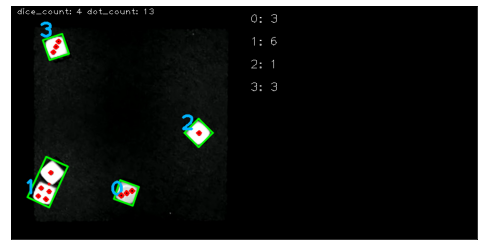

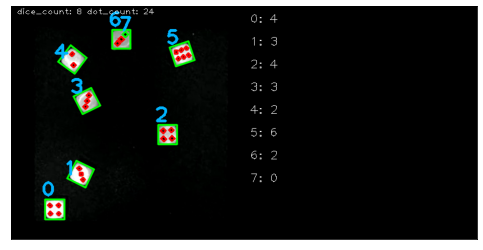

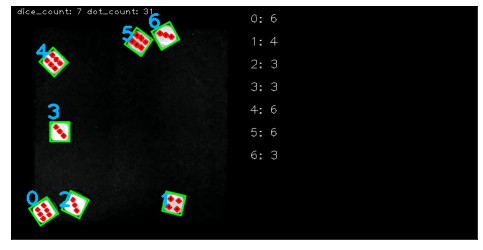

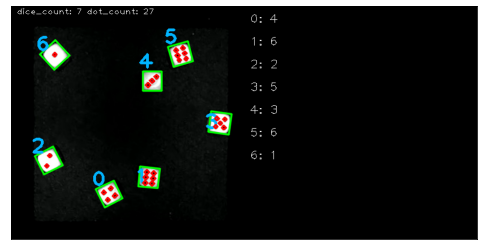

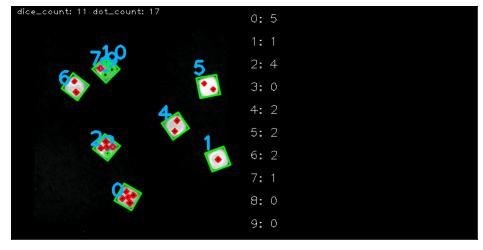

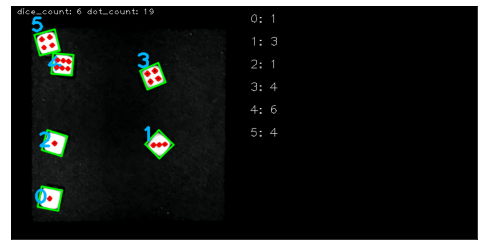

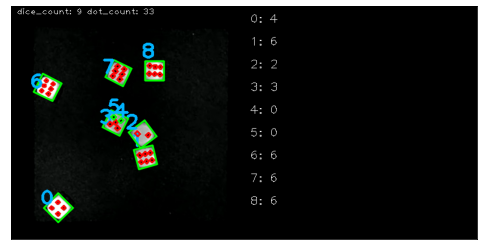

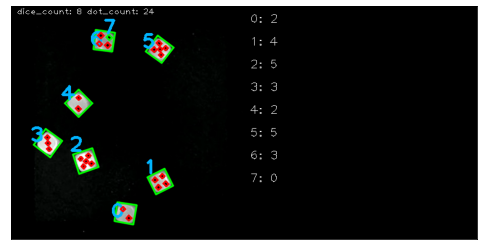

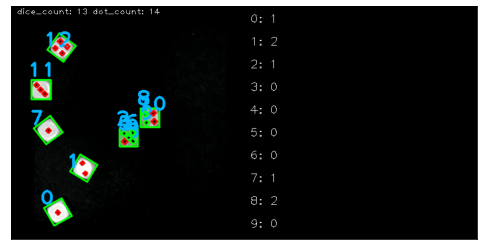

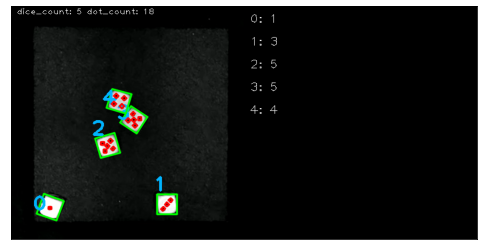

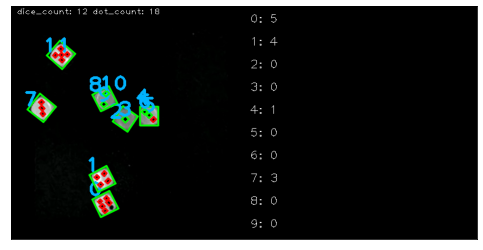

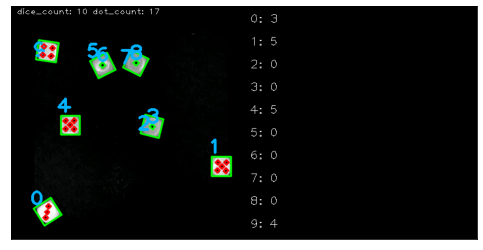

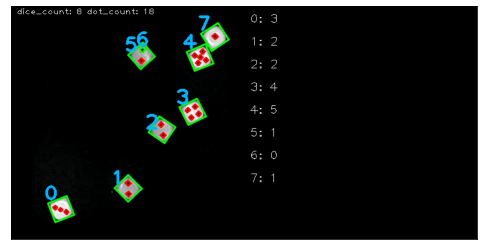

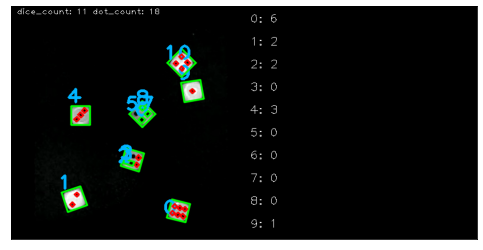

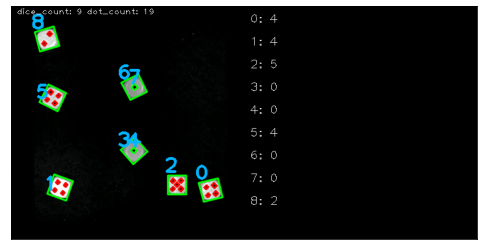

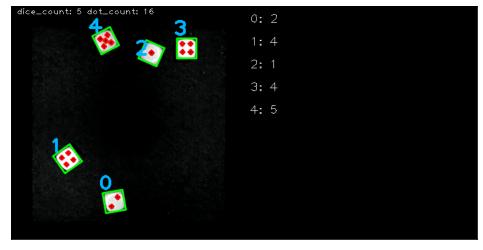

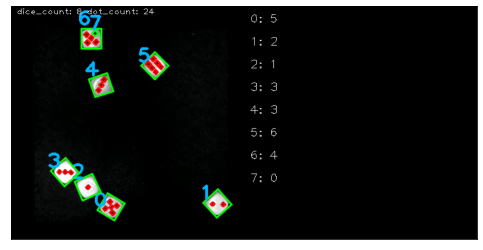

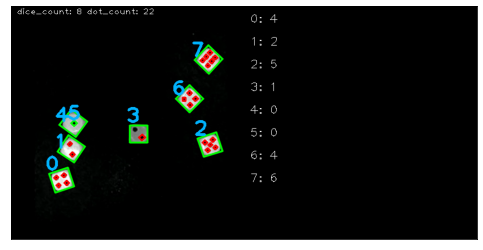

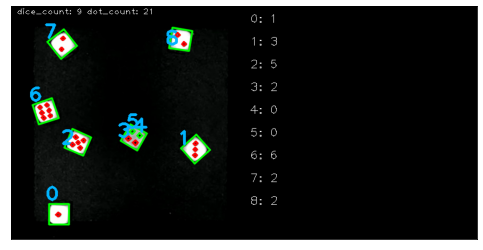

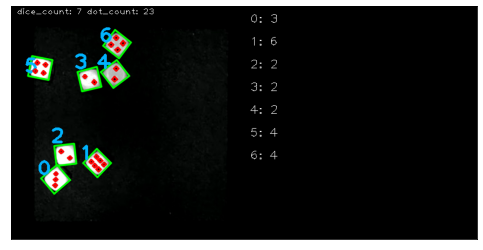

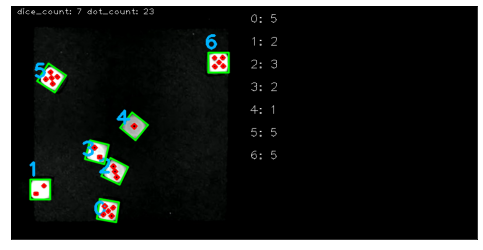

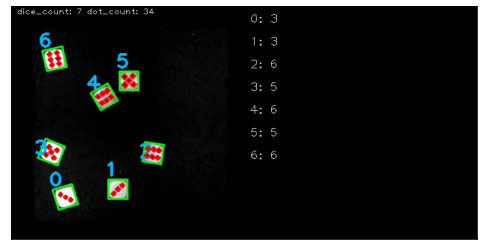

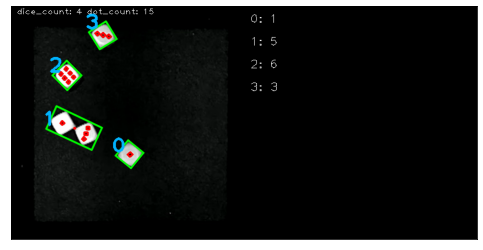

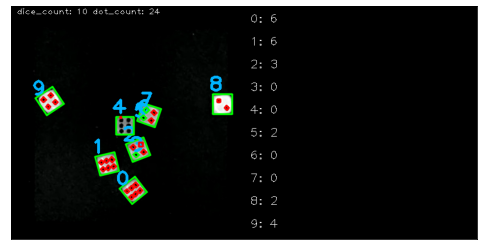

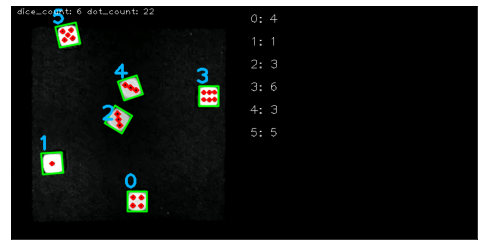

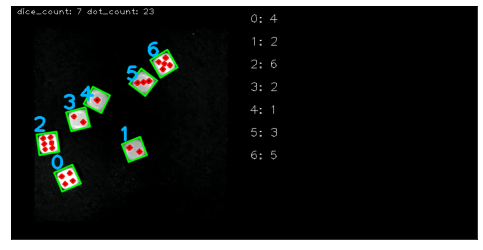

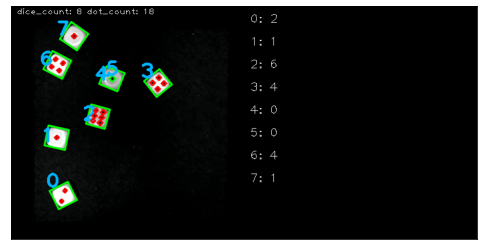

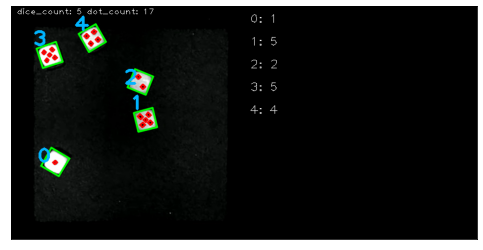

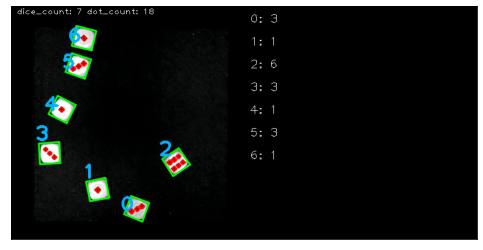

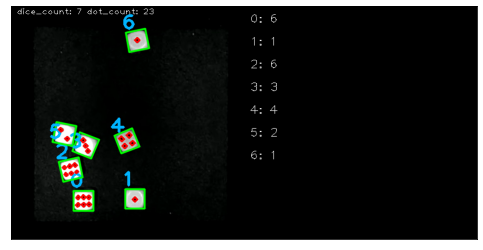

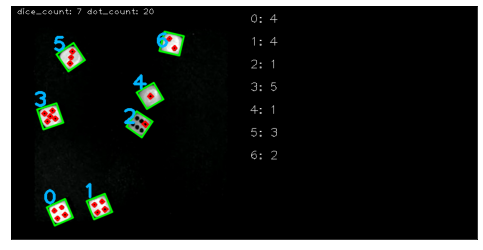

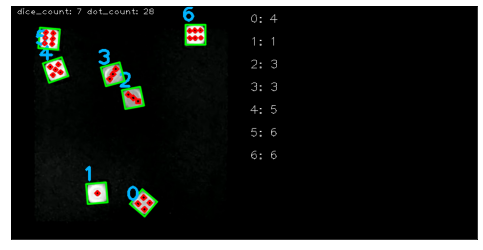

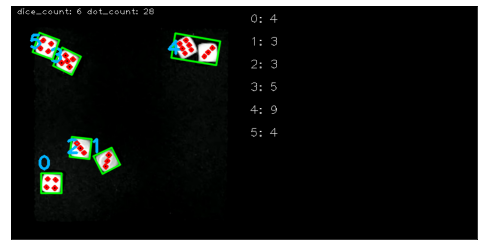

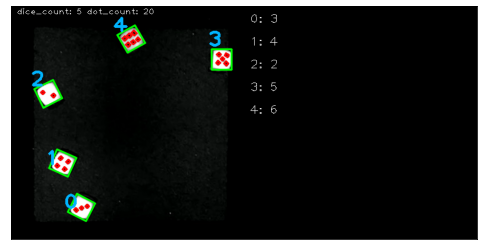

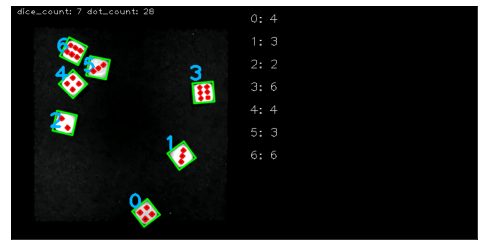

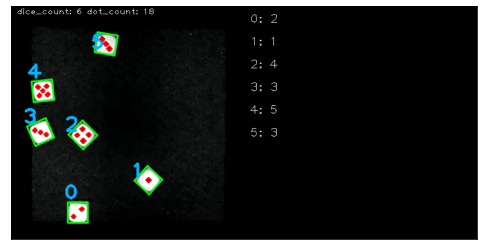

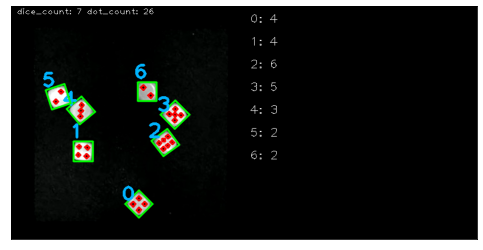

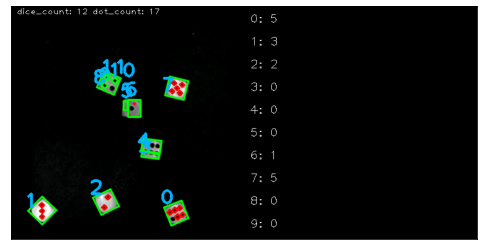

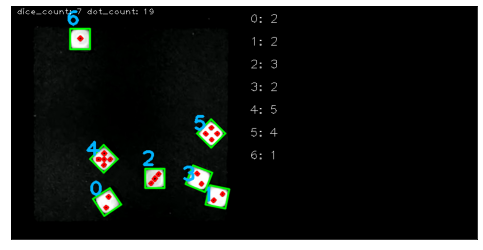

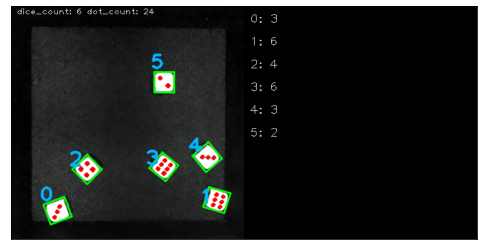

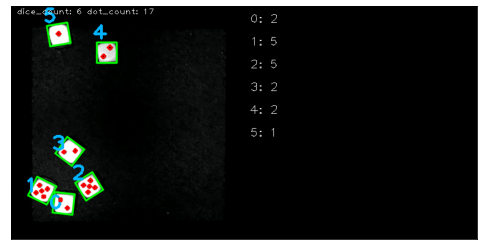

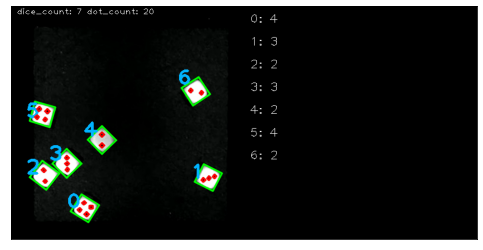

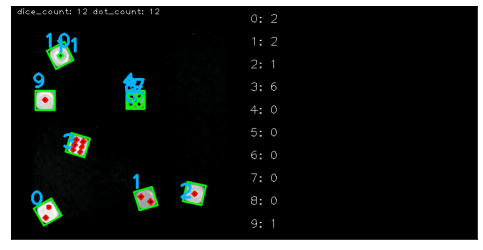

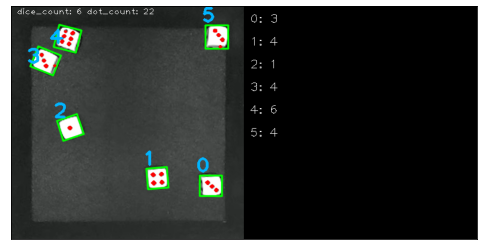

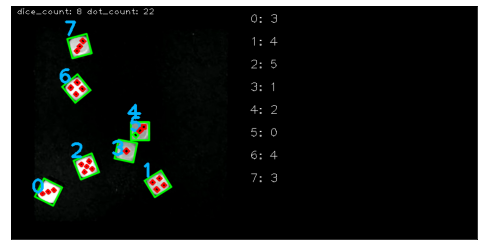

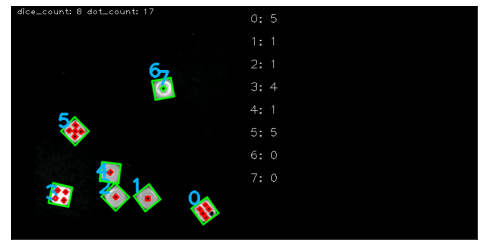

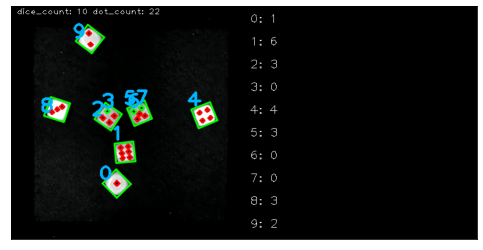

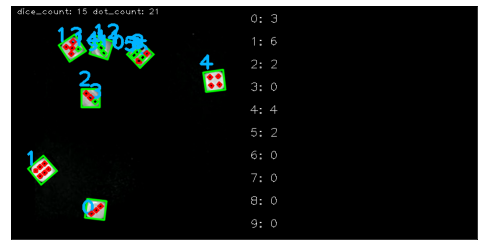

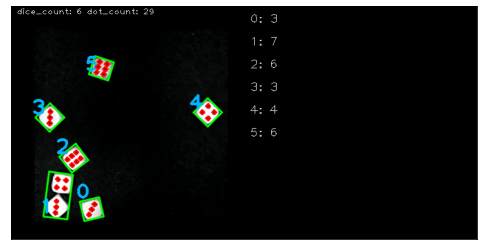

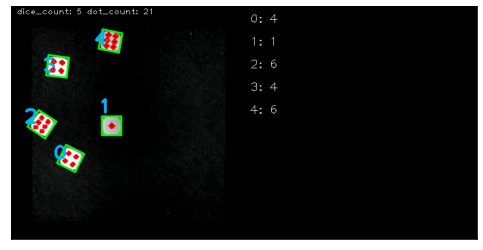

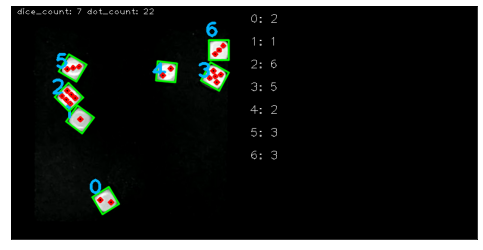

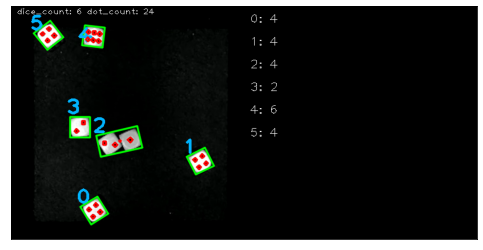

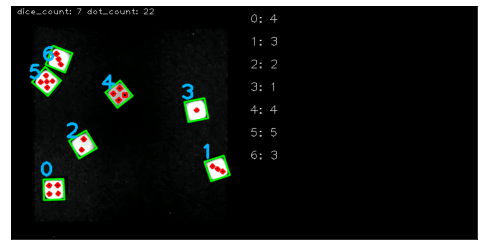

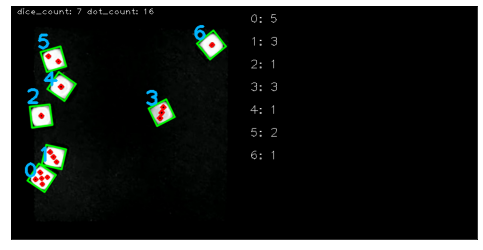

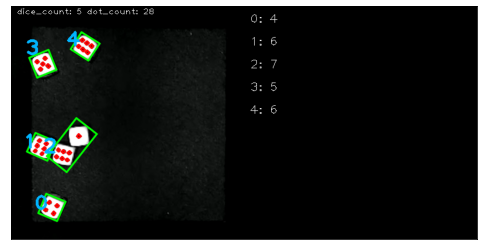

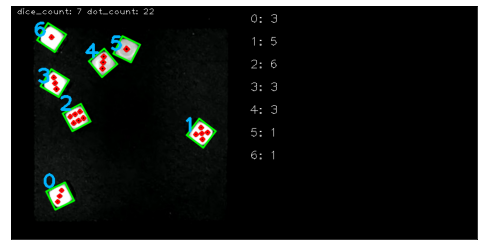

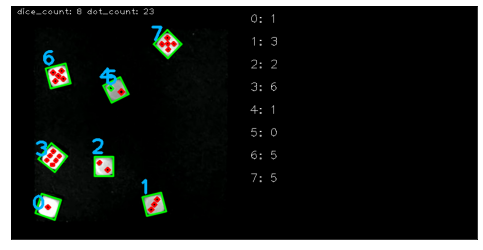

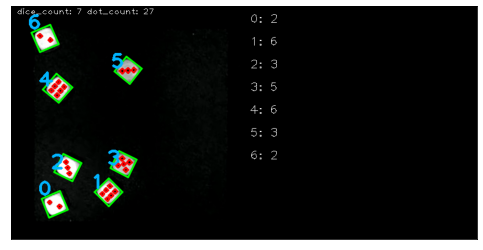

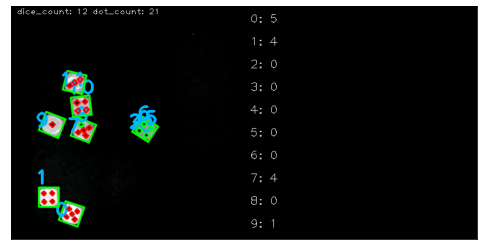

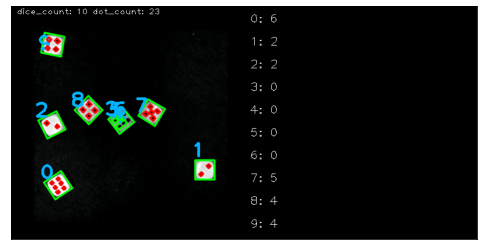

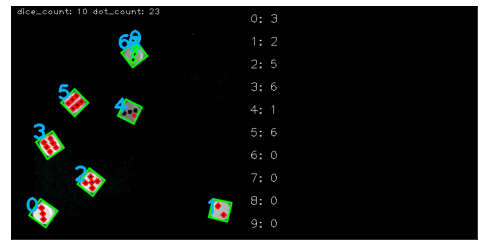

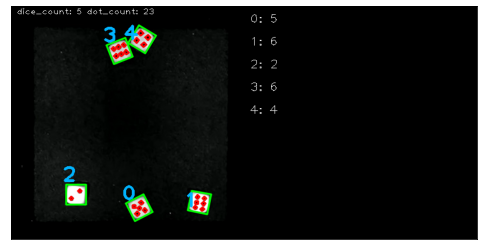

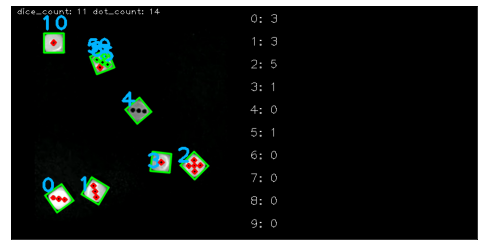

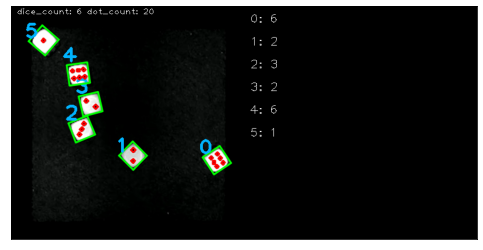

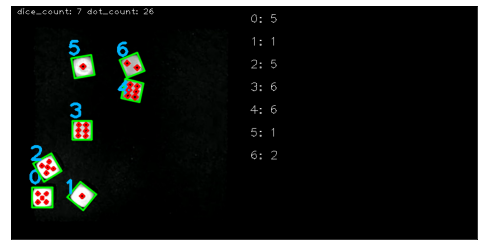

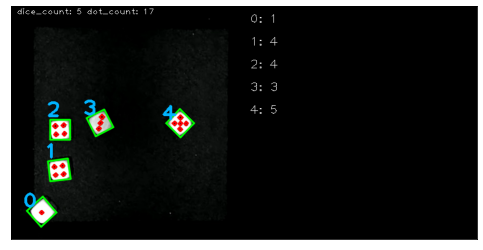

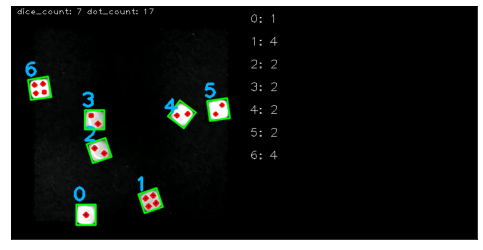

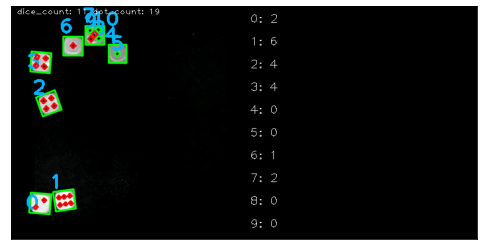

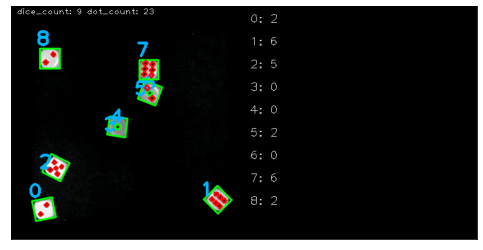

In [138]:
row_list = []

suma_oczko_all_iterations = 0
suma_dice_all_iterations = 0
iteration = 0
i = 0
dice_areas = []
for dice_image, original, dice_path in zip(dices, original_dices, dices_paths):
    
    
    plt.figure(figsize=(30, 30))
   
    # 5. Finding contours of an image.
    contours, _ = cv2.findContours(dice_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 6. Calculating areas of found contours.
    areas = []
    boxes_with_points = [] 
    for contour in contours:
        _, _, width, height = cv2.boundingRect(contour)
        areas.append(width*height)
        
    dice_areas.append(areas)

    # 6.1 Using average as a middle point to differ between dots and dices boxes
    labels = []
    dice_dict = {}
    dice_count = 0
    middle = (max(areas) - min(areas)) / 2
    avg_dot_area = 81
    avg_dice_area = 1888
        
    suma_area_oczko = 0
    suma_area_dice = 0
    oczko_count = 0
    for area in areas:
        
        if area < 80: 
            labels.append('oczko')
            
            suma_area_oczko += area
            oczko_count += 1
        
        else:
            labels.append('kostka')
            dice_dict[dice_count] = 0
            
            suma_area_dice += area
            dice_count += 1
            
        
    
    if oczko_count > 0 and dice_count > 0:
        suma_oczko_all_iterations += suma_area_oczko / oczko_count
        suma_dice_all_iterations += suma_area_dice / dice_count

    dice_count = 0
    dot_count = 0
    for contour, label in zip(contours, labels):
        
         # 7. Drawing contours according to labels.
        rectangle = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rectangle)
        box = np.int0(box)
        
        if label == 'kostka':
            cv2.drawContours(original, [box], -1, (0, 255, 0), 2,  cv2.LINE_AA)
            # 7.1 Displaying id of dice in a picture
            cv2.putText(original, str(dice_count), (box[0][0] - 7, box[0][1] - 5), cv2.FONT_HERSHEY_PLAIN, 2.5, (0, 180, 255), 3)
            dice_count += 1
            
            
        elif label == 'oczko':
            cv2.drawContours(original, [box], -1, (255, 0, 0), 2,  cv2.LINE_AA)
            
            # 7.2 If dice for a dot is found -> ++
            M = cv2.moments(contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            k = 0
            c = 0
            for label in labels:
                if label == 'kostka':
                    result = cv2.pointPolygonTest(contours[c], (cX, cY), False)
                    if result > 0:
                        dice_dict[k] += 1
                    k += 1
                c += 1
                    
            dot_count += 1
                        
    # 8. Put dice count and dot count text on a black image
    cv2.putText(original, "dice_count: "+ str(dice_count) + " dot_count: "+ str(dot_count), (10,15), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
    
    height, width, channels = original.shape
    # 9. Add blank black image and concatenate with original picture
    blank_image = np.zeros((height, width, channels), np.uint8)
    
    r = 30
    for key, value in dice_dict.items():
        cv2.putText(blank_image, str(key) + ": " + str(value), (10, r), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255))
        r += 40
        
    dices_walls_dict = {
        1: 0,
        2: 0,
        3: 0, 
        4: 0, 
        5: 0, 
        6: 0
    }
    # 10. Counting and saving T/F to an csv file, comparing dot_count with actual value
    for value in dice_dict.values():
        if 1 <= value <= 6:
            dices_walls_dict[value] += 1
    
    row = [
            dice_path,
            dice_count,
            dices_walls_dict[1],
            dices_walls_dict[2],
            dices_walls_dict[3],
            dices_walls_dict[4],
            dices_walls_dict[5],
            dices_walls_dict[6],
            dot_count]
    
    row_list.append(row)
        
    concatenated = cv2.hconcat([original, blank_image])
    ax = plt.subplot(6, 3, i+1)
    ax.imshow(concatenated)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, concatenated.shape[1], concatenated.shape[0], 0])
    
    iteration += 1
    
    
avg_area_oczko_all_iterations = suma_oczko_all_iterations / iteration 
avg_area_dice_all_iterations = suma_dice_all_iterations / iteration 
#print("Average area of dices dots: ", avg_area_oczko_all_iterations)
#print("Average area of dices: ", avg_area_dice_all_iterations)
    

## Saving results to an csv file

In [139]:
with open('dices/results/results_100_dices.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'dice_count', '1_count', '2_count', '3_count', '4_count', '5_count', '6_count', 'dot_sum'])
    writer.writerows(row_list)

## Experiments
### Averages of dices areas and dices dots areas.
At first, the average area of detected boxes was calculated ('middle').  Then, dices and dices dots were classified by labelling areas of boxes as follows: if the area was greater than the 'middle' value, then it was a dice, else it was dices' dot. Then these values were used to classify dots and dices by changing values which distinguished objects.    

    Average area of dices dots:  81.31931317543793   
    Average area of dices:  1888.6862380952382   



## Statistics
(dataset, result dataset, blur edge size, threshold value, erosion, dilation, avg_dot_area, avg_dice_area)

(100_dices.csv, results_100_dices.csv, (3, 3), 120, (1, 1), (3, 3), 81, 1888)

In [140]:
# Add a new column and sort file in ascending order by its values
df = pd.read_csv("dices/results/results_100_dices.csv")
df["splitted"] = df["filename"].agg([lambda f: int(f.split('/')[3].split('.')[0])])
sorted_df = df.sort_values(by=["splitted"], ascending=True)

sorted_df.to_csv('./dices/results/sorted_100_dices.csv')
sorted_df        

filename  dice_count  1_count  2_count  3_count  4_count  \
37    ./dices/100_dices/1.jpg           9        0        1        1        1   
0     ./dices/100_dices/2.jpg           7        1        0        2        0   
13    ./dices/100_dices/3.jpg           7        0        0        0        3   
30    ./dices/100_dices/4.jpg           7        1        1        3        1   
76    ./dices/100_dices/5.jpg           8        3        0        0        1   
..                        ...         ...      ...      ...      ...      ...   
78   ./dices/100_dices/96.jpg          15        0        2        1        2   
3    ./dices/100_dices/97.jpg           6        1        2        1        0   
48   ./dices/100_dices/98.jpg           8        1        1        0        2   
56   ./dices/100_dices/99.jpg           7        1        2        1        1   
64  ./dices/100_dices/100.jpg           5        0        1        1        1   

    5_count  6_count  dot_sum  splitted  
37        0        4       33         1  
0         2        2       29         2  
13        4        0       32         3  
30        1        0       21         4  
76        2        0       17         5  
..      ...      ...      ...       ...  
78        0        1       21        96  
3         1        0       20        97  
48        1        1       22        98  
56        1        1       23        99  
64        1        1       20       100  

[100 rows x 10 columns]

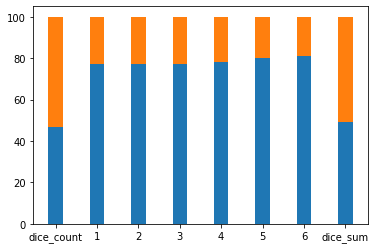

In [143]:
source = './100_dices.csv'
sted = './dices/results/sorted_100_dices.csv'
stats = './dices/stats/stats_100_dices.csv'
# Iterate through 100_dices.csv and sorted_100_dices.csv and save to stats_100_dices.csv
with open(source, 'r', newline='') as f1, open(sted, 'r', newline='') as f2, open(stats, 'w', newline='') as f3:
    
    # Create reader for 100_dices.csv and sorted_100_dices.csv
    reader_f1 = csv.reader(f1)
    reader_f2 = csv.reader(f2)
    # Omit header
    next(reader_f1)
    next(reader_f2)
    
    true_count = {
        'dice_count': 0,
        1: 0,
        2: 0,
        3: 0, 
        4: 0, 
        5: 0, 
        6: 0,
        'dice_sum': 0
    }

    false_count = {
        'dice_count': 0,
        1: 0,
        2: 0,
        3: 0, 
        4: 0, 
        5: 0, 
        6: 0,
        'dice_sum': 0
    }
    
    # Generalized csv contains info if dice faces numbers were the same or not
    option = 'generalized'
    writer = csv.writer(f3)
    if option == 'generalized':
        
        
        for row1, row2 in zip(reader_f1, reader_f2):
            row3 = [row1[0]]
            
            # When number of recognized dices in 100_dices.csv and sorted_100_dices.csv is the same, then add 1
            if row1[1] == row2[2]:
                row3.append(1)
                true_count['dice_count'] += 1
            else:
                row3.append(0)
                false_count['dice_count'] += 1
                
            
            i = 1
            for column1, column2 in zip(row1[2:-1], row2[3:-2]):
                
                # When number of recogized faces in 100_dices.csv and sorted_100_dices.csv is the same, then add 1 
                if column1 == column2:
                    row3.append(1)
                    true_count[i] += 1
                else:
                    row3.append(0)
                    false_count[i] += 1
                    
                i += 1
                
                
            # When number of recognized sum in 100_dices.csv and sorted_100_dices.csv is the same, then add 1
            if row1[-1] == row2[-2]:
                row3.append(1)
                true_count['dice_sum'] += 1
            else:
                row3.append(0)
                false_count['dice_sum'] += 1
            
            
            writer.writerow(row3)
            #print(row1, row2, row3) 
        
        vals_true = [val for val in true_count.values()]
        vals_false = [val for val in false_count.values()]
        xticks = ['dice_count', '1', '2', '3', '4', '5', '6', 'dice_sum']
        fig, ax = plt.subplots()
        ax.bar(xticks, vals_true, 0.35, label='True')
        ax.bar(xticks, vals_false, 0.35, label='False', bottom=vals_true)
        #ax.set_ylabel()
        ax.set_title('Generalized')
        plt.show()
        ax.legend()               
        
                        
    # detailed csv contains info what was the difference between actual and recognized number of faces
    elif option == 'detailed':
        pass
    
    
    
    